In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words:
words = open('names.txt','r').read().splitlines()
# build the vocab of chars and mappings:
chars = sorted(set(''.join(words)))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [4]:
# build the dataset:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [36]:
# compare manual gradients to pytorch gradients

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10
n_hidden = 64  

C = torch.randn((vocab_size, n_embd))
# layer 1:
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn((1, n_hidden)) * 0.1
# layer 2:
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn((vocab_size)) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size

# construct a mini-batch:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

In [ ]:
emb = C[Xb] # embed the chars into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# linear layer 1:
hprebn = embcat @ W1 + b1
# BatchNorm Layer:
bnmeani = 1 / n * hprebn.sum(0, keepdim=True) # we want the mean for 32 samples that why -> (32, 64) -> (1, 64)
bndiff = hprebn - bnmeani # center the activations (subtract mean)
bndiff2 = bndiff ** 2
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True) # Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv # normalize so -> mean = 0 & variane = 1
hpreact = bngain * bnraw + bnbias
# non linearity:
h = torch.tanh(hpreact)
# linear layer 2:
logits = h @ W2 + b2 # output layer
# cross entropy loss:
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability (e ^ {logits})
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1 # if you use (1.0 / counts_sum) instead, then you can't get backprop to match exactly to pytorch
probs = counts * counts_sum_inv # counts (32, 27), counts_sum_inv = (32, 1) so broadcasting happens
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass:
for p in parameters:
    p.grad = None

for t in [
    logprobs, probs, counts, counts_sum, counts_sum_inv,
    norm_logits, logit_maxes, logits, h, hpreact, bnraw,
    bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
    embcat, emb
]:
    t.retain_grad()

loss.backward()
loss

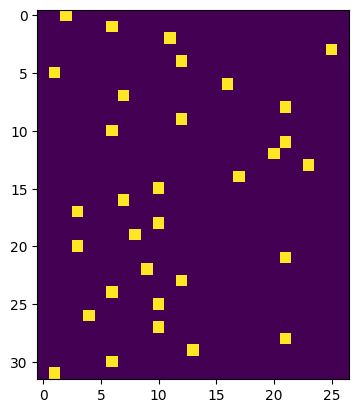

In [28]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])) # it will return an array size (32, 27) and the indexes that contain the max_value will be 1 and the others will be zero

In [71]:
# backprop through the whole thing manualy using the chain rule:

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # (32, 1)
dcounts = counts_sum_inv * dprobs # broadcasting will happen
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
#print(dlogit_maxes) # should be near zero
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
db2 = dlogits.sum(0, keepdim=True)
dW2 = h.T @ dlogits # (64, 32) x (32, 27) = (64, 27)
dh = dlogits @ W2.T # (32, 27) x (27, 64) = (32, 64)
dhpreact = (1.0 - h**2) * dh
dbnbias = dhpreact.sum(0, keepdim=True) # (1, 64)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # (1, 64)
dbnraw = bngain * dhpreact # (32, 64)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff.sum(0, keepdim=True))
dhprebn += (1 / n) * torch.ones_like(hprebn) * dbnmeani
db1 = dhprebn.sum(0, keepdim=False)
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]): # batch_size
    for j in range(Xb.shape[1]): # context_size
        i = Xb[k][j]
        dC[i] += demb[k][j]


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('b2', db2, b2)
cmp('W2', dW2, W2)
cmp('h', dh, h)
cmp('hpreact', dhpreact, hpreact)
cmp('bnbias', dbnbias, bnbias)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('b1', db1, b1)
cmp('W1', dW1, W1)
cmp('embcat', dembcat, embcat)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# more efficient way to backpropagate:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits) # we will get very close

logits          | exact: False | approximate: True  | maxdiff: 5.3551048040390015e-09


In [116]:
F.softmax(logits, 1)[0]

tensor([0.0233, 0.0492, 0.1198, 0.0946, 0.0298, 0.0263, 0.0143, 0.0275, 0.0326,
        0.0150, 0.0550, 0.0322, 0.0296, 0.0265, 0.0101, 0.0295, 0.0753, 0.0283,
        0.0145, 0.0207, 0.0549, 0.0369, 0.0246, 0.0185, 0.0147, 0.0447, 0.0516],
       grad_fn=<SelectBackward0>)

In [115]:
dlogits[0] * n

tensor([ 0.0233,  0.0492,  0.1198,  0.0946,  0.0298,  0.0263,  0.0143,  0.0275,
         0.0326,  0.0150,  0.0550,  0.0322,  0.0296,  0.0265,  0.0101, -0.9705,
         0.0753,  0.0283,  0.0145,  0.0207,  0.0549,  0.0369,  0.0246,  0.0185,
         0.0147,  0.0447,  0.0516], grad_fn=<MulBackward0>)

In [117]:
dlogits[0].sum()

tensor(0., grad_fn=<SumBackward0>)

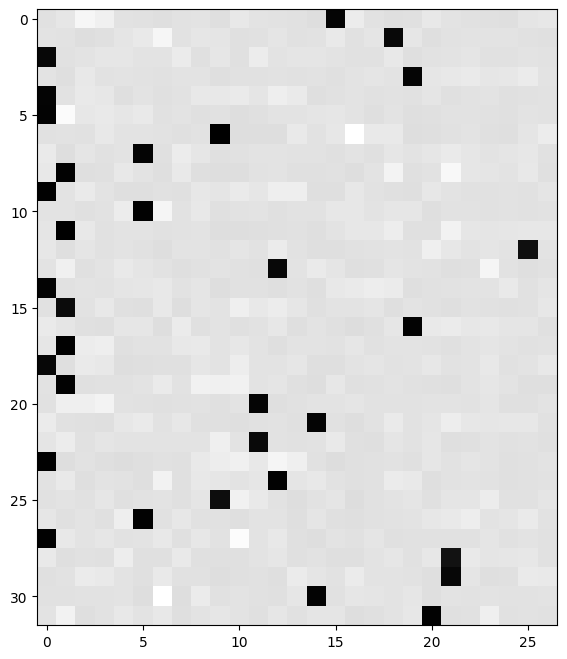

In [118]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='grey')

In [123]:
# more efficient way to backpropagate through the Batch-Norm Layer:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09
